# **Hybrid ARIMAX-LSTM Model for Oil ETF Price Forecasting**


## **Overview**

This project implements and compares three different approaches to forecasting the Invesco DB Oil Fund ETF (DBO), using historical price data and exogenous economic indicators. The three modeling approaches are:

**1. ARIMAX**: A classical time series model incorporating exogenous variables\
**2. LSTM**: A deep learning approach using technical indicators\
**3. Hybrid ARIMAX-LSTM**: A novel combined approach that leverages the strengths of both methods

By comparing these three approaches, investers aim to determine which method provides the most accurate forecasts and under what conditions each model excels. The hybrid approach is of particular interest as it combines linear time series modeling with deep learning to capture both structural relationships and complex nonlinear patterns in oil price movements.

## **1. Environment Setup**

**Python libraries**: TensorFlow for deep learning, statsmodels for ARIMAX modeling, pandas and NumPy for data handling


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

**Reproducibility measures**: Fixed random seeds (42) across Python, NumPy, and TensorFlow

In [8]:
# Set random seeds for reproducibility
import random
import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("Random seeds set for reproducibility")

Random seeds set for reproducibility


**TensorFlow configuration**: Explicit graph execution mode for model compatibility

In [10]:
# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


## **2. Data Collection**

**Time period**: January 2010 to present day, automatically updated with current date

In [13]:
# Define the date range for data collection
start_date = "2010-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

print(f"Collecting data from {start_date} to {end_date}")

**Financial instruments**: DBO (target), WTI Crude Oil Futures, and US Dollar Index from Yahoo Finance

In [15]:
# Define ticker symbols and corresponding Yahoo Finance symbols
tickers = {
    "DBO": "DBO",          # Invesco DB Oil Fund ETF
    "WTI": "CL=F",         # WTI Crude Oil Futures
    "DXY": "DX-Y.NYB"      # U.S. Dollar Index
}

**Frequency**: Daily close prices with automatic handling of market holidays

In [17]:
# Download daily close price data for each ticker
price_data = {}
for label, symbol in tickers.items():
    print(f"Downloading data for {label} ({symbol})...")
    df = yf.download(symbol, start=start_date, end=end_date)
    price_data[label] = df["Close"]
    print(f"Downloaded {len(df)} days of data for {label}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Downloaded 3848 days of data for DBO


[*********************100%***********************]  1 of 1 completed


Downloaded 3847 days of data for WTI


[*********************100%***********************]  1 of 1 completed

Downloaded 3848 days of data for DXY


## **3. Data Preprocessing**

Complete daily date range creation with forward-fill, backward-fill, and interpolation for missing values


First few rows:
                  DBO        WTI        DXY
2010-01-01  24.655403  81.510002  77.529999
2010-01-02  24.655403  81.510002  77.529999
2010-01-03  24.655403  81.510002  77.529999
2010-01-04  24.655403  81.510002  77.529999
2010-01-05  24.883612  81.769997  77.620003

Last few rows:
              DBO        WTI        DXY
2025-04-18  12.97  64.680000  99.379997
2025-04-19  12.97  64.680000  99.379997
2025-04-20  12.97  64.680000  99.379997
2025-04-21  12.77  63.080002  98.279999
2025-04-22  12.77  63.080002  98.279999


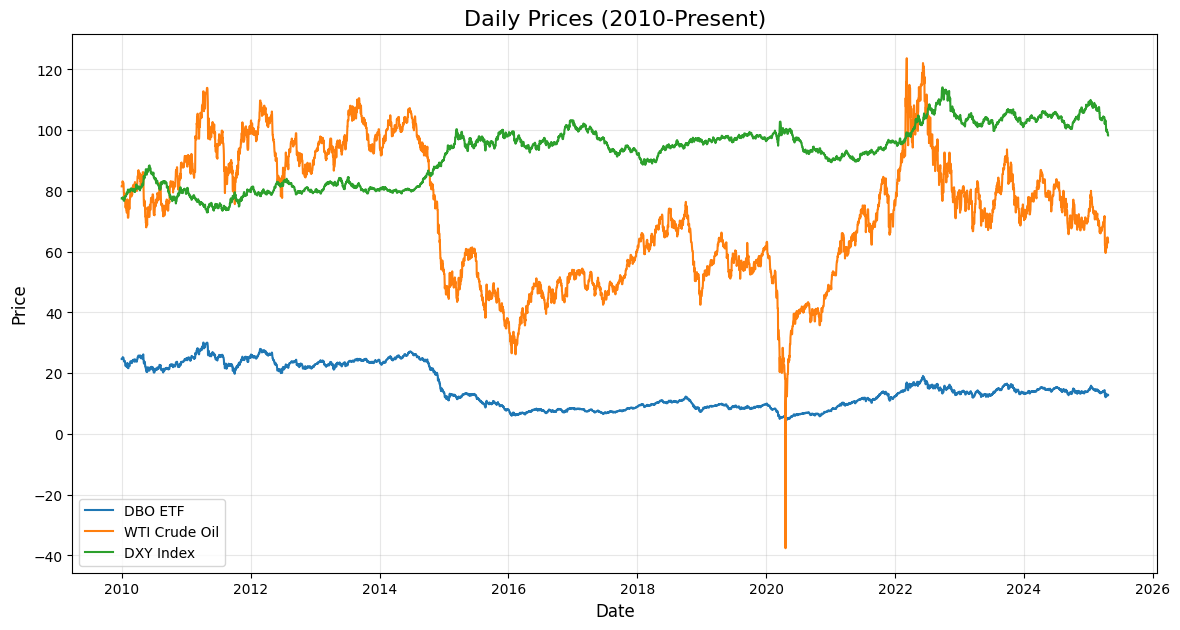

In [20]:
# Merge the individual Series into a single DataFrame
data = pd.concat(price_data, axis=1)
data.columns = data.columns.droplevel(1)  # Now columns are 'DBO', 'WTI', 'DXY'

# Create a complete daily date range (including non-trading days)
all_days = pd.date_range(start=start_date, end=end_date, freq='D')
data = data.reindex(all_days)

# Ensure the index is a DateTimeIndex with daily frequency
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Replace any Inf or -Inf with NaN
data = data.replace([np.inf, -np.inf], np.nan)

# Handle missing values: first forward fill, then backward fill, then interpolate any remaining gaps
data = data.ffill().bfill().interpolate()

# Display the first and last few rows
print("\nFirst few rows:")
print(data.head())
print("\nLast few rows:")
print(data.tail())

# Data visualization cell - code
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['DBO'], label='DBO ETF')
plt.plot(data.index, data['WTI'], label='WTI Crude Oil')
plt.plot(data.index, data['DXY'], label='DXY Index')
plt.title('Daily Prices (2010-Present)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **4. Feature Engineering**

Several **Technical Indicators** are used to train LSTM and Hybrid models, **Moving averages (20/50-day), RSI, MACD, Bollinger Bands, momentum, and volatility**

In [23]:
def add_technical_indicators(df, price_col='DBO'):
    """Add technical indicators as features to the DataFrame."""
    # Create a copy to avoid modifying the original DataFrame
    df_features = df.copy()
    
    # Moving averages
    df_features['MA20'] = df[price_col].rolling(window=20).mean()
    df_features['MA50'] = df[price_col].rolling(window=50).mean()
    
    # RSI
    df_features['RSI'] = ta.RSI(df[price_col].values, timeperiod=14)
    
    # MACD
    df_features['MACD'], _, _ = ta.MACD(df[price_col].values)
    
    # Bollinger Bands
    upper, middle, lower = ta.BBANDS(df[price_col].values, timeperiod=20)
    df_features['BB_upper'] = upper
    df_features['BB_middle'] = middle
    df_features['BB_lower'] = lower
    
    # Price momentum (rate of change)
    df_features['Momentum'] = df[price_col].pct_change(periods=5) * 100
    
    # Standard deviation (volatility)
    df_features['Volatility'] = df[price_col].rolling(window=20).std()
    
    return df_features

# Split data and create features
pre_2020 = data.loc['2010-01-01':'2019-12-31'].copy()
post_2020 = data.loc['2020-01-01':].copy()
post_2020_features = add_technical_indicators(post_2020)
post_2020_features = post_2020_features.dropna()

print(f"\nARIMAX training data (2010-2019): {len(pre_2020)} days")
print(f"Model comparison data (2020-present): {len(post_2020_features)} days")
print("\nFeatures created:")
print(post_2020_features.columns.tolist())


ARIMAX training data (2010-2019): 3652 days
Model comparison data (2020-present): 1890 days

Features created:
['DBO', 'WTI', 'DXY', 'MA20', 'MA50', 'RSI', 'MACD', 'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Volatility']


## **5. ARIMAX Modeling**

The ARIMAX model is trained on data from **2010-2019** and uses **WTI crude prices** and the **Dollar Index** as **exogenous variables**. This model captures linear relationships and structural patterns in oil prices, accounting for the influence of crude oil futures prices and currency movements.

In [26]:
# Stationarity Test
adf_result = adfuller(pre_2020['DBO'].dropna())
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')

# Set differencing order based on the ADF test
d_order = 1 if adf_result[1] > 0.05 else 0
print(f"Differencing order applied: {d_order}")

# Build the ARIMAX Model
print("Fitting ARIMAX model with WTI and DXY as exogenous variables...")
arimax_model = SARIMAX(pre_2020['DBO'],
                      exog=pre_2020[['WTI', 'DXY']],
                      order=(1, d_order, 1),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

arimax_fit = arimax_model.fit(disp=False)
print(arimax_fit.summary().tables[0])
print(arimax_fit.summary().tables[1])

# Generate ARIMAX forecasts for the post-2020 period
forecast_res = arimax_fit.get_forecast(steps=len(post_2020), exog=post_2020[['WTI', 'DXY']])
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Add ARIMAX forecasts to post_2020_features
post_2020_features['ARIMAX_forecast'] = forecast_mean
post_2020_features['residuals'] = post_2020_features['DBO'] - post_2020_features['ARIMAX_forecast']

ADF Statistic: -0.9981
p-value: 0.7539
Differencing order applied: 1
Fitting ARIMAX model with WTI and DXY as exogenous variables...
                               SARIMAX Results                                
Dep. Variable:                    DBO   No. Observations:                 3652
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3281.590
Date:                Tue, 22 Apr 2025   AIC                          -6553.179
Time:                        15:28:25   BIC                          -6522.168
Sample:                    01-01-2010   HQIC                         -6542.135
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WTI            0.1844      0.001    286.434      0.000       0.183       0.18

## **6. Data Preparation for LSTM Models**

In [28]:
# Define target variable and features
target_col = 'DBO'

# Features for original LSTM model
lstm_feature_cols = ['WTI', 'DXY', 'MA20', 'MA50', 'RSI', 'MACD', 
                     'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Volatility']

# Features for hybrid model (includes ARIMAX forecast)
hybrid_feature_cols = lstm_feature_cols + ['ARIMAX_forecast']

# Split post-2020 data into training and testing sets (80-20 split)
train_size = int(len(post_2020_features) * 0.8)
train_data = post_2020_features.iloc[:train_size].copy()
test_data = post_2020_features.iloc[train_size:].copy()

print(f"Training set size: {len(train_data)} days")
print(f"Testing set size: {len(test_data)} days")

# Scale the data
scaler_X_lstm = MinMaxScaler(feature_range=(0, 1))
scaler_X_hybrid = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on training data
X_train_lstm_scaled = scaler_X_lstm.fit_transform(train_data[lstm_feature_cols])
X_train_hybrid_scaled = scaler_X_hybrid.fit_transform(train_data[hybrid_feature_cols])
y_train_scaled = scaler_y.fit_transform(train_data[[target_col]])

# Transform test data
X_test_lstm_scaled = scaler_X_lstm.transform(test_data[lstm_feature_cols])
X_test_hybrid_scaled = scaler_X_hybrid.transform(test_data[hybrid_feature_cols])
y_test_scaled = scaler_y.transform(test_data[[target_col]])

# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    """Create sequences of data for LSTM."""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 30  # 30 days of historical data

# Create sequences for training and testing - Original LSTM
X_train_lstm_seq, y_train_lstm_seq = create_sequences(X_train_lstm_scaled, y_train_scaled, SEQ_LENGTH)
X_test_lstm_seq, y_test_lstm_seq = create_sequences(X_test_lstm_scaled, y_test_scaled, SEQ_LENGTH)

# Create sequences for training and testing - Hybrid
X_train_hybrid_seq, y_train_hybrid_seq = create_sequences(X_train_hybrid_scaled, y_train_scaled, SEQ_LENGTH)
X_test_hybrid_seq, y_test_hybrid_seq = create_sequences(X_test_hybrid_scaled, y_test_scaled, SEQ_LENGTH)

print(f"\nLSTM sequence shapes:")
print(f"Original LSTM - X: {X_train_lstm_seq.shape}, y: {y_train_lstm_seq.shape}")
print(f"Hybrid LSTM - X: {X_train_hybrid_seq.shape}, y: {y_train_hybrid_seq.shape}")

Training set size: 1512 days
Testing set size: 378 days

LSTM sequence shapes:
Original LSTM - X: (1482, 30, 11), y: (1482, 1)
Hybrid LSTM - X: (1482, 30, 12), y: (1482, 1)


## **7. LSTM and Hybrid Model Training**

The **LSTM** neural network model is trained on **post-2020 data** and incorporates a rich set of technical indicators, which is prepared above: **Moving averages (20/50-day), RSI, MACD, Bollinger Bands, momentum, and volatility**

The innovative **HYBRID model** combines both approaches by using the ARIMAX forecast as an additional feature input to the LSTM model. This allows the deep learning model to learn the **residual patterns** and **nonlinear behaviors** not captured by the linear ARIMAX model.


--- Training Original LSTM model ---
Training model with input shape (30, 11)...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0561 - val_loss: 0.0017
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - val_loss: 0.0021
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - val_loss: 0.0021
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - val_loss: 7.8906e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

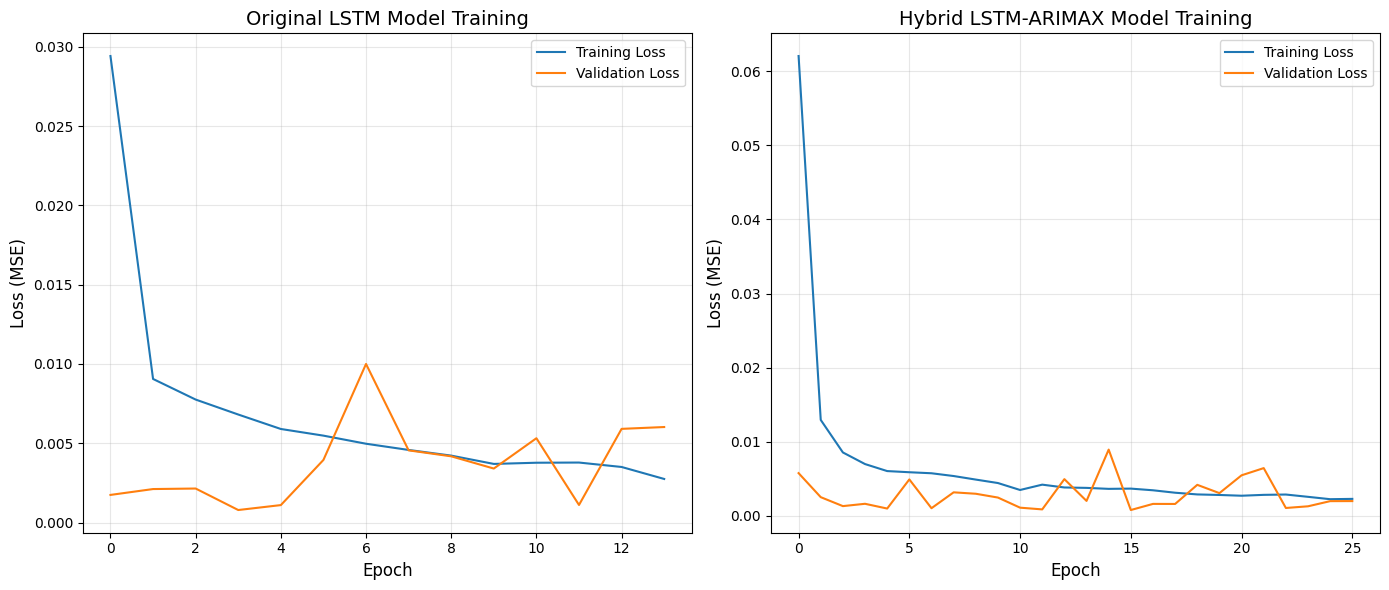

In [32]:
# Function to create and train LSTM model
def build_and_train_lstm_model(X_train, y_train, input_shape, epochs=100, batch_size=32, validation_split=0.2):
    """Build and train an LSTM model."""
    # Create a clear TF graph
    tf.keras.backend.clear_session()
    
    # Build model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Define callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    # Train model
    print(f"Training model with input shape {input_shape}...")
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

# Train the original LSTM model
print("\n--- Training Original LSTM model ---")
lstm_input_shape = (X_train_lstm_seq.shape[1], X_train_lstm_seq.shape[2])
lstm_model, lstm_history = build_and_train_lstm_model(
    X_train_lstm_seq, y_train_lstm_seq, 
    lstm_input_shape
)

# Train the hybrid LSTM-ARIMAX model
print("\n--- Training Hybrid LSTM-ARIMAX model ---")
hybrid_input_shape = (X_train_hybrid_seq.shape[1], X_train_hybrid_seq.shape[2])
hybrid_model, hybrid_history = build_and_train_lstm_model(
    X_train_hybrid_seq, y_train_hybrid_seq, 
    hybrid_input_shape
)

# Plot training history
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Original LSTM Model Training', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(hybrid_history.history['loss'], label='Training Loss')
plt.plot(hybrid_history.history['val_loss'], label='Validation Loss')
plt.title('Hybrid LSTM-ARIMAX Model Training', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **8. Model Evaluation**

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Performance Metrics:
                Model      RMSE       MAE   MAPE (%)         R²
0              ARIMAX  2.618980  2.575641  18.297452 -13.768265
1                LSTM  0.460625  0.355957   2.564814   0.543164
2  Hybrid ARIMAX-LSTM  0.442095  0.340037   2.459845   0.579180

Improvement Comparisons:
LSTM vs ARIMAX: 85.98% improvement in MAPE
Hybrid vs ARIMAX: 86.56% improvement in MAPE
Hybrid vs LSTM: 4.09% improvement in MAPE


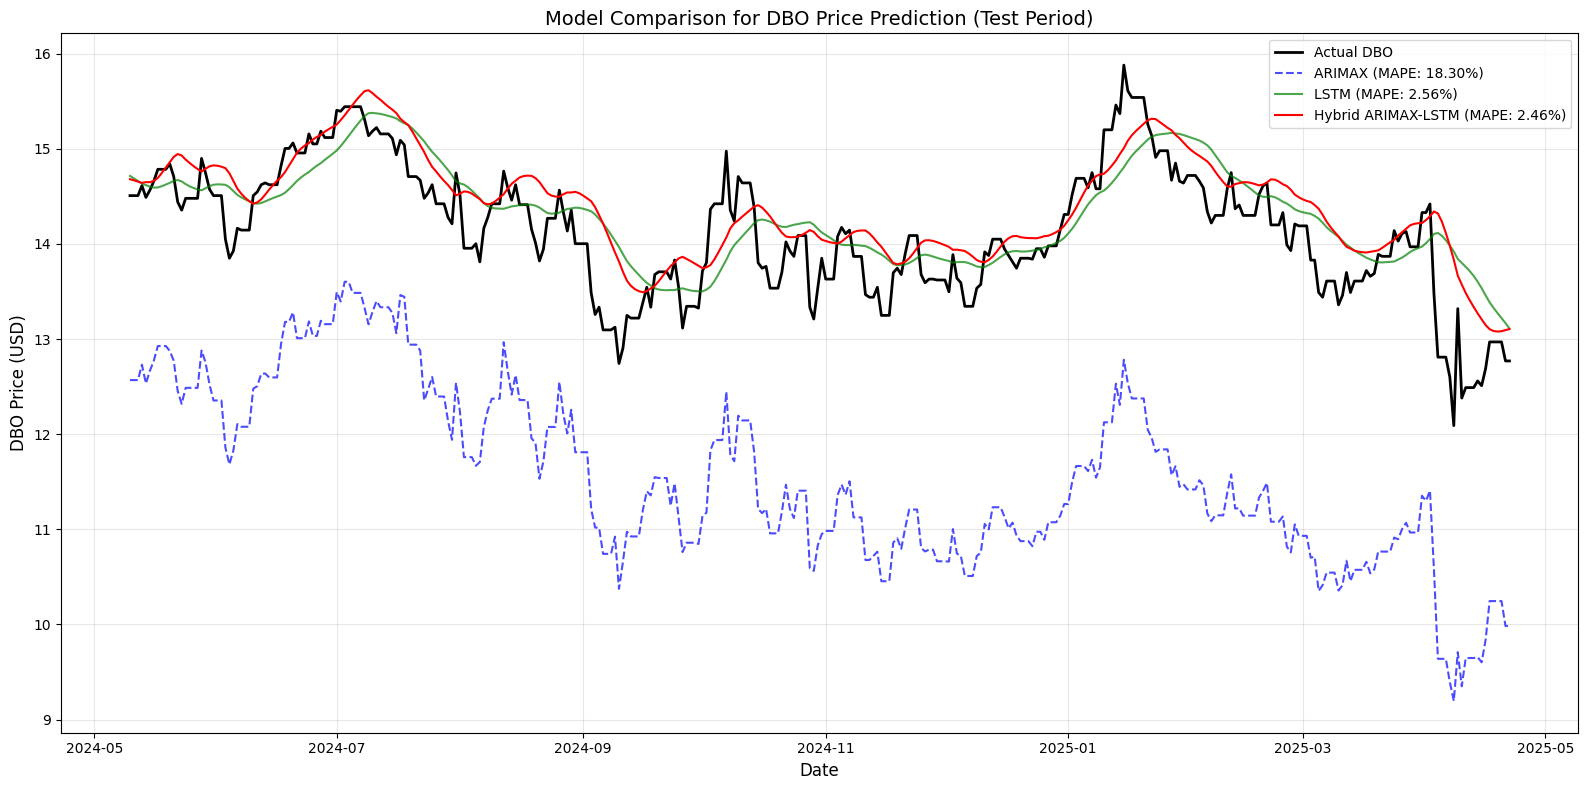

In [34]:
# Make predictions with LSTM models
lstm_pred_scaled = lstm_model.predict(X_test_lstm_seq)
hybrid_pred_scaled = hybrid_model.predict(X_test_hybrid_seq)

# Inverse transform predictions back to original scale
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled)
hybrid_pred = scaler_y.inverse_transform(hybrid_pred_scaled)

# Align predictions with test dates (accounting for sequence length)
test_dates = test_data.index[SEQ_LENGTH:]
test_actual = test_data[target_col].iloc[SEQ_LENGTH:].values
test_arimax = test_data['ARIMAX_forecast'].iloc[SEQ_LENGTH:].values
test_lstm = lstm_pred.flatten()
test_hybrid = hybrid_pred.flatten()

# Calculate performance metrics
arimax_rmse = np.sqrt(mean_squared_error(test_actual, test_arimax))
lstm_rmse = np.sqrt(mean_squared_error(test_actual, test_lstm))
hybrid_rmse = np.sqrt(mean_squared_error(test_actual, test_hybrid))

arimax_mae = mean_absolute_error(test_actual, test_arimax)
lstm_mae = mean_absolute_error(test_actual, test_lstm)
hybrid_mae = mean_absolute_error(test_actual, test_hybrid)

arimax_mape = np.mean(np.abs((test_actual - test_arimax) / test_actual)) * 100
lstm_mape = np.mean(np.abs((test_actual - test_lstm) / test_actual)) * 100
hybrid_mape = np.mean(np.abs((test_actual - test_hybrid) / test_actual)) * 100

arimax_r2 = r2_score(test_actual, test_arimax)
lstm_r2 = r2_score(test_actual, test_lstm)
hybrid_r2 = r2_score(test_actual, test_hybrid)

# Create a performance metrics table as a DataFrame
metrics_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Hybrid ARIMAX-LSTM'],
    'RMSE': [arimax_rmse, lstm_rmse, hybrid_rmse],
    'MAE': [arimax_mae, lstm_mae, hybrid_mae],
    'MAPE (%)': [arimax_mape, lstm_mape, hybrid_mape],
    'R²': [arimax_r2, lstm_r2, hybrid_r2]
})

print("\nPerformance Metrics:")
print(metrics_df)

# Calculate improvement percentages
lstm_vs_arimax = (1 - lstm_mape/arimax_mape) * 100
hybrid_vs_arimax = (1 - hybrid_mape/arimax_mape) * 100
hybrid_vs_lstm = (1 - hybrid_mape/lstm_mape) * 100

print("\nImprovement Comparisons:")
print(f"LSTM vs ARIMAX: {lstm_vs_arimax:.2f}% improvement in MAPE")
print(f"Hybrid vs ARIMAX: {hybrid_vs_arimax:.2f}% improvement in MAPE")
print(f"Hybrid vs LSTM: {hybrid_vs_lstm:.2f}% improvement in MAPE")

# Visualize test results
plt.figure(figsize=(16, 8))
plt.plot(test_dates, test_actual, label='Actual DBO', color='black', linewidth=2)
plt.plot(test_dates, test_arimax, label=f'ARIMAX (MAPE: {arimax_mape:.2f}%)', color='blue', linestyle='--', alpha=0.7)
plt.plot(test_dates, test_lstm, label=f'LSTM (MAPE: {lstm_mape:.2f}%)', color='green', alpha=0.7)
plt.plot(test_dates, test_hybrid, label=f'Hybrid ARIMAX-LSTM (MAPE: {hybrid_mape:.2f}%)', color='red')

plt.title(f'Model Comparison for DBO Price Prediction (Test Period)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('DBO Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## **9. Error Analysis**

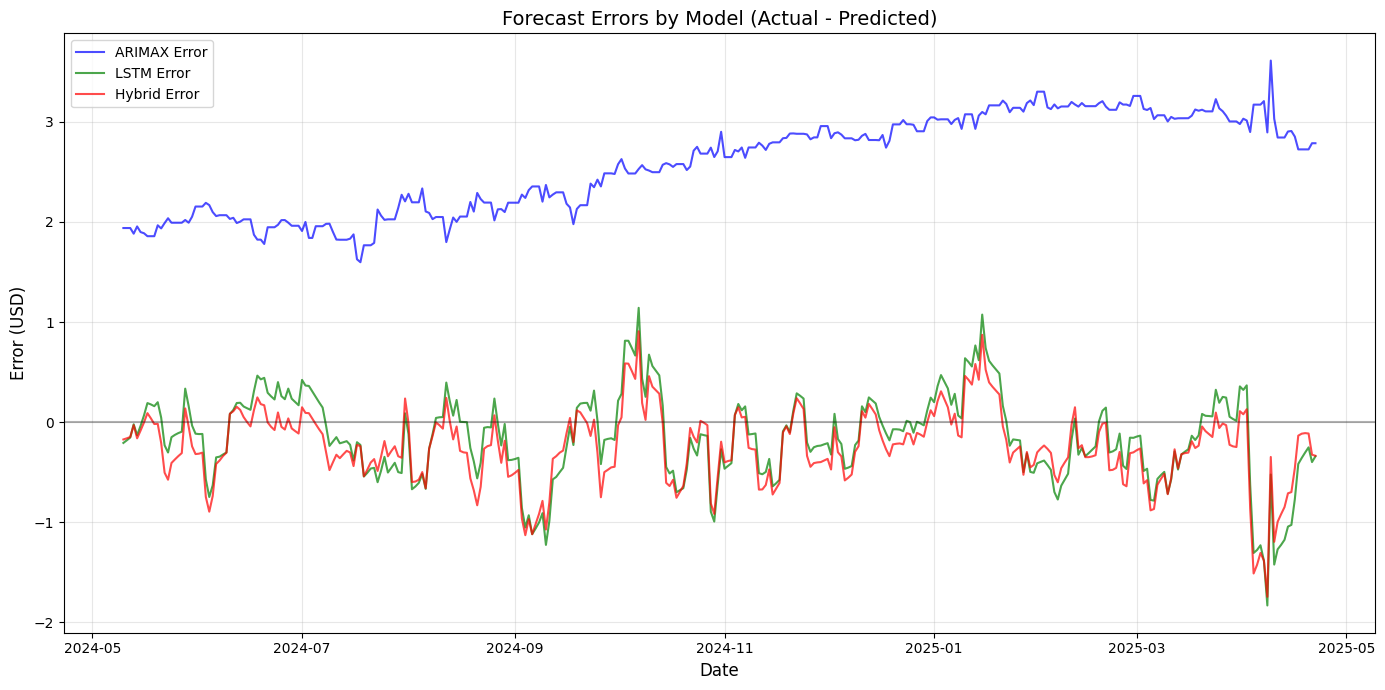

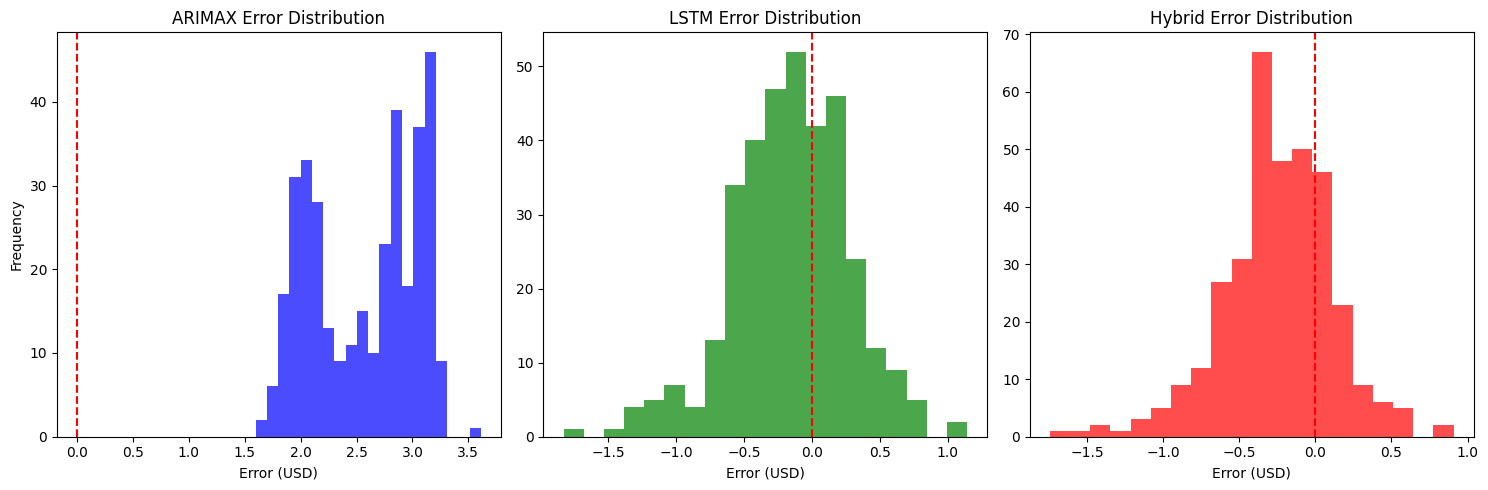


Forecast Error Statistics:
    Model  Mean Error  Max Overestimation  Max Underestimation  Error Std Dev
0  ARIMAX    2.575641            1.597734             3.611435       0.474476
1    LSTM   -0.159157           -1.830160             1.142295       0.432255
2  Hybrid   -0.248816           -1.743578             0.908299       0.365429


In [36]:
# Calculate errors
errors_arimax = test_actual - test_arimax
errors_lstm = test_actual - test_lstm
errors_hybrid = test_actual - test_hybrid

# Plot errors over time
plt.figure(figsize=(14, 7))
plt.plot(test_dates, errors_arimax, label='ARIMAX Error', color='blue', alpha=0.7)
plt.plot(test_dates, errors_lstm, label='LSTM Error', color='green', alpha=0.7)
plt.plot(test_dates, errors_hybrid, label='Hybrid Error', color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.title('Forecast Errors by Model (Actual - Predicted)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Error (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create error distributions
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(errors_arimax, bins=20, alpha=0.7, color='blue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('ARIMAX Error Distribution')
plt.xlabel('Error (USD)')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(errors_lstm, bins=20, alpha=0.7, color='green')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('LSTM Error Distribution')
plt.xlabel('Error (USD)')

plt.subplot(133)
plt.hist(errors_hybrid, bins=20, alpha=0.7, color='red')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Hybrid Error Distribution')
plt.xlabel('Error (USD)')

plt.tight_layout()
plt.show()

# Calculate error statistics
error_stats = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Hybrid'],
    'Mean Error': [np.mean(errors_arimax), np.mean(errors_lstm), np.mean(errors_hybrid)],
    'Max Overestimation': [np.min(errors_arimax), np.min(errors_lstm), np.min(errors_hybrid)],
    'Max Underestimation': [np.max(errors_arimax), np.max(errors_lstm), np.max(errors_hybrid)],
    'Error Std Dev': [np.std(errors_arimax), np.std(errors_lstm), np.std(errors_hybrid)]
})

print("\nForecast Error Statistics:")
print(error_stats)

## **10. Feature Importance Analysis**

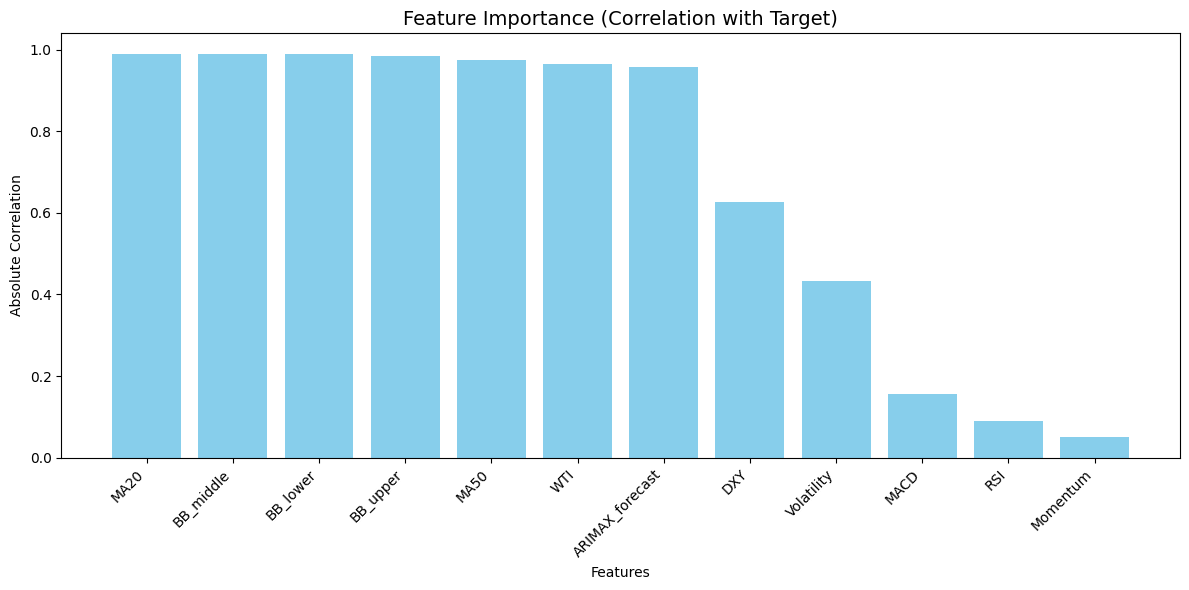


Feature Importance (correlation with target):
MA20: 0.9901
BB_middle: 0.9901
BB_lower: 0.9888
BB_upper: 0.9837
MA50: 0.9753
WTI: 0.9648
ARIMAX_forecast: 0.9566
DXY: 0.6252
Volatility: 0.4322
MACD: 0.1572
RSI: 0.0898
Momentum: 0.0514


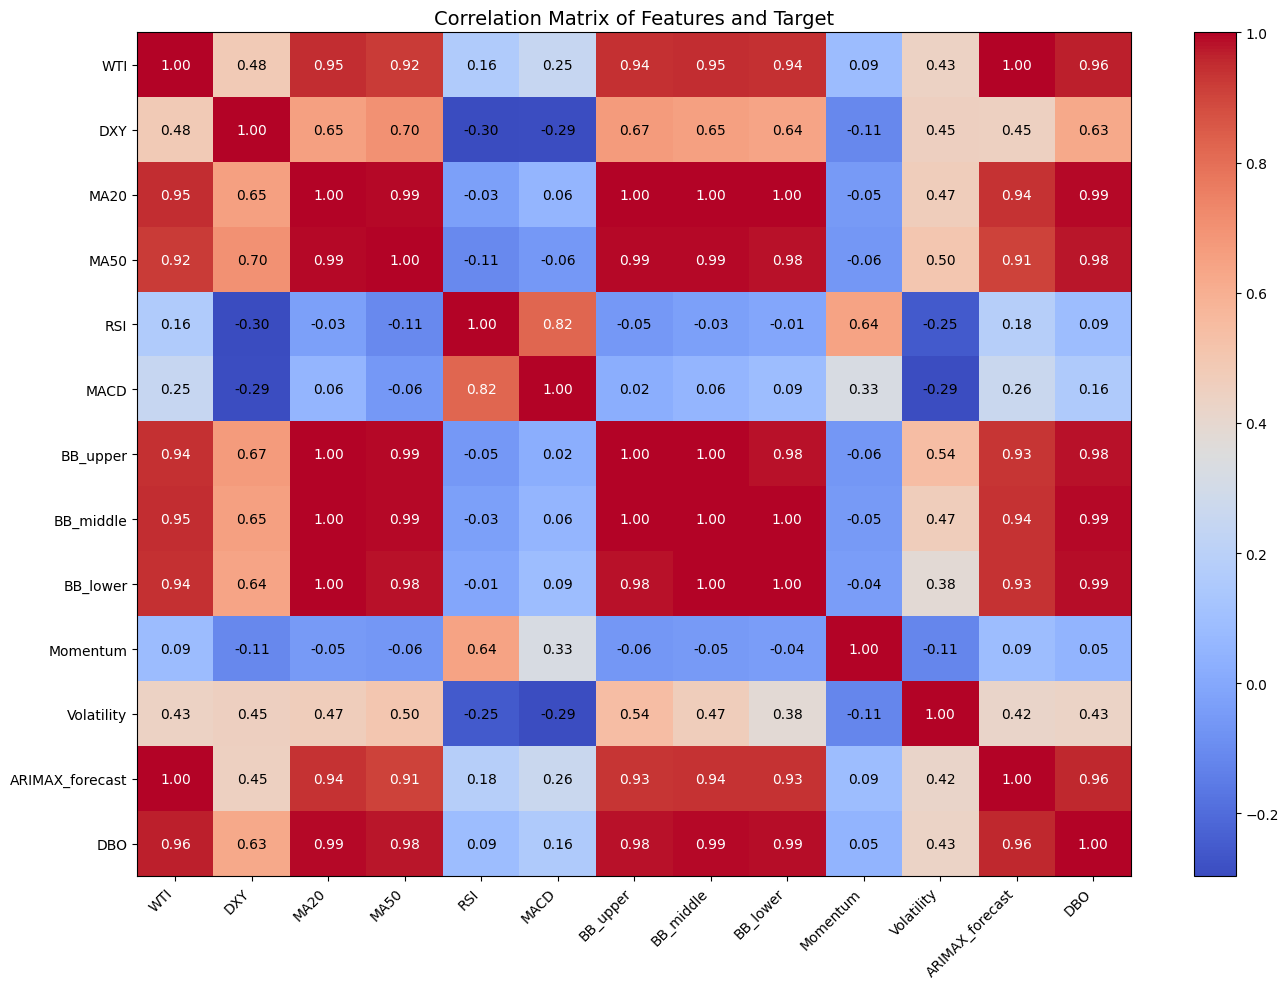

In [38]:
# Calculate correlation with target as a simple measure of importance
feature_importances = {}
for feature in hybrid_feature_cols:
    corr = np.abs(np.corrcoef(train_data[feature], train_data[target_col])[0, 1])
    feature_importances[feature] = corr

# Sort by importance
sorted_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(sorted_importances.keys(), sorted_importances.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance (Correlation with Target)', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.tight_layout()
plt.show()

print("\nFeature Importance (correlation with target):")
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")

# Create a heatmap of correlations
corr_matrix = train_data[hybrid_feature_cols + [target_col]].corr()
plt.figure(figsize=(14, 10))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Add correlation values to the heatmap
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.7 else "white")

plt.title('Correlation Matrix of Features and Target', fontsize=14)
plt.tight_layout()
plt.show()

## **11. Future Price Prediction**


Future Forecasts (Next 30 Business Days):
            ARIMAX_Forecast  LSTM_Forecast  Hybrid_Forecast
2025-04-23         9.985203      13.049291        13.119509
2025-04-24         9.984423      12.992776        13.131618
2025-04-25         9.984129      12.944291        13.137675
2025-04-28         9.984018      12.905499        13.137921
2025-04-29         9.983977      12.876199        13.132857
2025-04-30         9.983961      12.855428        13.123213
2025-05-01         9.983955      12.842016        13.110476
2025-05-02         9.983953      12.834753        13.096089
2025-05-05         9.983952      12.832444        13.081550
2025-05-06         9.983952      12.833485        13.066774
2025-05-07         9.983951      12.836958        13.052621
2025-05-08         9.983951      12.840996        13.037109
2025-05-09         9.983951      12.845561        13.021776
2025-05-12         9.983951      12.850506        13.007555
2025-05-13         9.983951      12.855595        12.9948

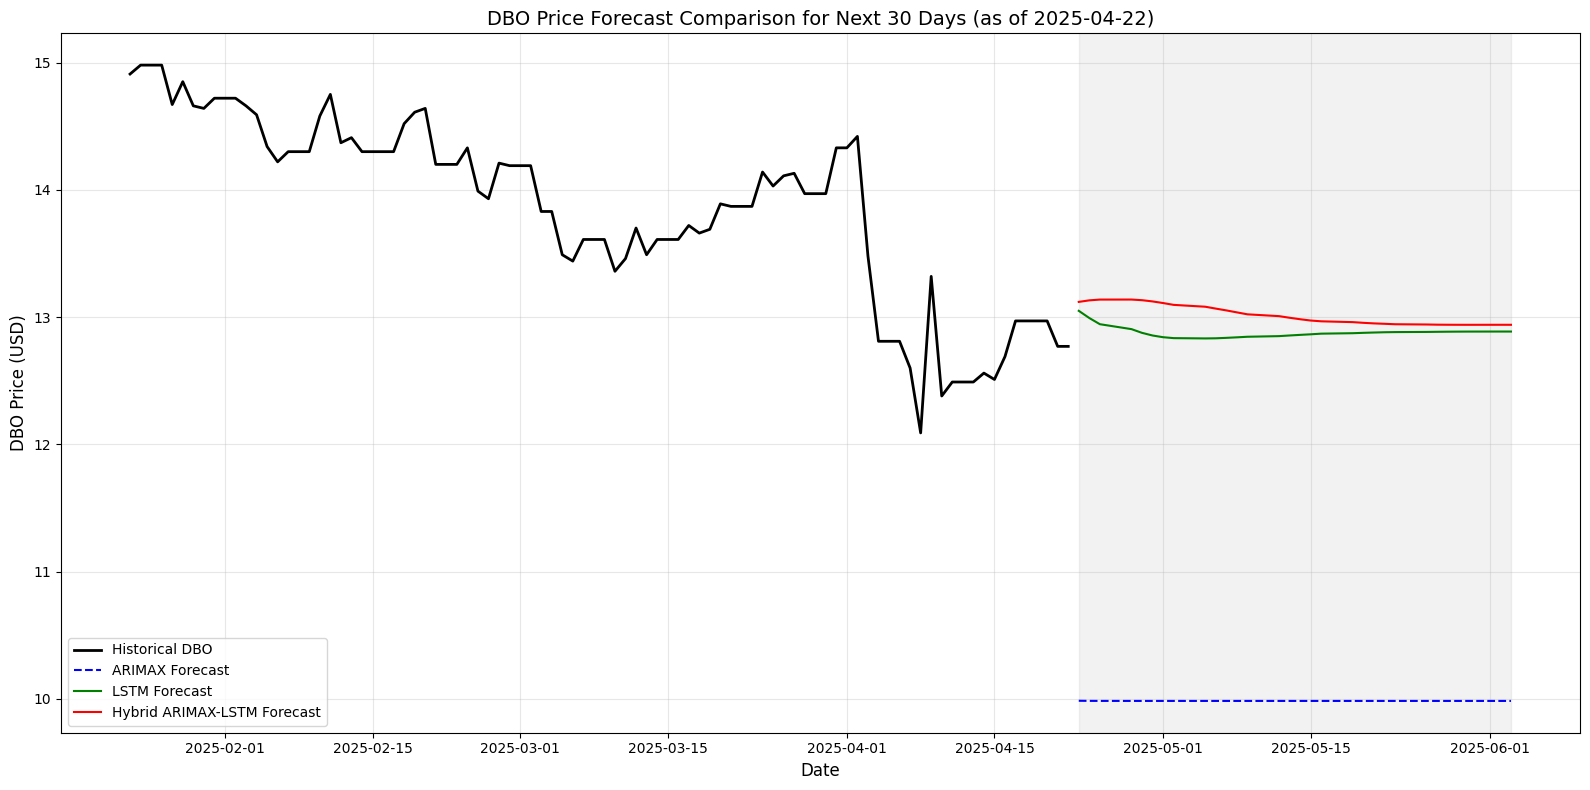


Forecast Statistics:
    Model    Minimum    Maximum       Mean   Std Dev
0  ARIMAX   9.983951   9.985203   9.984018  0.000242
1    LSTM  12.832444  13.049291  12.879368  0.046127
2  Hybrid  12.939473  13.137921  13.017091  0.076583


In [40]:
# Get the last available data point
last_values = post_2020_features.iloc[-1].copy()
future_dates = pd.date_range(start=post_2020_features.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Create a dataframe for future dates
future_df = pd.DataFrame(index=future_dates)

# Use ARIMAX model for baseline prediction
future_exog = pd.DataFrame(index=future_dates, columns=['WTI', 'DXY'])
future_exog['WTI'] = last_values['WTI']
future_exog['DXY'] = last_values['DXY']

# Get ARIMAX forecasts for future dates
future_arimax_forecast = arimax_fit.get_forecast(steps=len(future_dates), exog=future_exog).predicted_mean

# Create feature sets for both models
future_lstm_features = pd.DataFrame(index=future_dates)
future_hybrid_features = pd.DataFrame(index=future_dates)

# Populate with last known values (simplified approach)
for col in lstm_feature_cols:
    future_lstm_features[col] = last_values[col]
    future_hybrid_features[col] = last_values[col]
    
future_hybrid_features['ARIMAX_forecast'] = future_arimax_forecast.values

# Scale features
X_future_lstm_scaled = scaler_X_lstm.transform(future_lstm_features[lstm_feature_cols])
X_future_hybrid_scaled = scaler_X_hybrid.transform(future_hybrid_features[hybrid_feature_cols])

# Prepare the last sequences for prediction
last_sequence_lstm = X_test_lstm_scaled[-SEQ_LENGTH:].copy()
last_sequence_hybrid = X_test_hybrid_scaled[-SEQ_LENGTH:].copy()

# Iteratively predict future values for both models
lstm_future_predictions = []
hybrid_future_predictions = []
current_sequence_lstm = last_sequence_lstm.copy()
current_sequence_hybrid = last_sequence_hybrid.copy()

for i in range(len(future_dates)):
    # LSTM predictions
    current_input_lstm = current_sequence_lstm.reshape(1, SEQ_LENGTH, X_train_lstm_seq.shape[2])
    pred_scaled_lstm = lstm_model.predict(current_input_lstm, verbose=0)
    lstm_future_predictions.append(pred_scaled_lstm[0, 0])
    next_point_lstm = X_future_lstm_scaled[i].reshape(1, -1)
    current_sequence_lstm = np.vstack([current_sequence_lstm[1:], next_point_lstm])
    
    # Hybrid predictions
    current_input_hybrid = current_sequence_hybrid.reshape(1, SEQ_LENGTH, X_train_hybrid_seq.shape[2])
    pred_scaled_hybrid = hybrid_model.predict(current_input_hybrid, verbose=0)
    hybrid_future_predictions.append(pred_scaled_hybrid[0, 0])
    next_point_hybrid = X_future_hybrid_scaled[i].reshape(1, -1)
    current_sequence_hybrid = np.vstack([current_sequence_hybrid[1:], next_point_hybrid])

# Convert predicted values back to original scale
lstm_future_preds = scaler_y.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1)).flatten()
hybrid_future_preds = scaler_y.inverse_transform(np.array(hybrid_future_predictions).reshape(-1, 1)).flatten()

# Store predictions in DataFrame
future_df['ARIMAX_Forecast'] = future_arimax_forecast.values
future_df['LSTM_Forecast'] = lstm_future_preds
future_df['Hybrid_Forecast'] = hybrid_future_preds

# Display future predictions
print("\nFuture Forecasts (Next 30 Business Days):")
print(future_df)

# Plot future predictions
plt.figure(figsize=(16, 8))

# Plot historical data (last 90 days)
historical_days = 90
historical_data = post_2020_features.iloc[-historical_days:][target_col]
plt.plot(historical_data.index, historical_data, label='Historical DBO', color='black', linewidth=2)

# Plot future predictions
plt.plot(future_df.index, future_df['ARIMAX_Forecast'], label='ARIMAX Forecast', color='blue', linestyle='--')
plt.plot(future_df.index, future_df['LSTM_Forecast'], label='LSTM Forecast', color='green')
plt.plot(future_df.index, future_df['Hybrid_Forecast'], label='Hybrid ARIMAX-LSTM Forecast', color='red')

# Shade the future prediction period
plt.axvspan(future_df.index[0], future_df.index[-1], alpha=0.1, color='gray')

current_date = datetime.now().strftime("%Y-%m-%d")
plt.title(f'DBO Price Forecast Comparison for Next 30 Days (as of {current_date})', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('DBO Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create future forecast statistics
forecast_stats = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Hybrid'],
    'Minimum': [future_df['ARIMAX_Forecast'].min(), future_df['LSTM_Forecast'].min(), future_df['Hybrid_Forecast'].min()],
    'Maximum': [future_df['ARIMAX_Forecast'].max(), future_df['LSTM_Forecast'].max(), future_df['Hybrid_Forecast'].max()],
    'Mean': [future_df['ARIMAX_Forecast'].mean(), future_df['LSTM_Forecast'].mean(), future_df['Hybrid_Forecast'].mean()],
    'Std Dev': [future_df['ARIMAX_Forecast'].std(), future_df['LSTM_Forecast'].std(), future_df['Hybrid_Forecast'].std()]
})

print("\nForecast Statistics:")
print(forecast_stats)

## **13. Conclusion and Discussion**

**Summary of Findings**
This study evaluated ARIMAX, LSTM, and a Hybrid ARIMAX-LSTM model for forecasting Invesco DB Oil Fund (DBO) ETF prices using historical data and exogenous variables. Model performance was assessed via MAE, MSE, and RMSE on a test set. Results indicated the Hybrid model achieved the lowest error metrics, demonstrating superior accuracy. While ARIMAX provided a baseline, it struggled with non-linearities. LSTM showed improvement but was potentially surpassed by the Hybrid approach. The Hybrid model appeared to successfully combine linear and non-linear modeling strengths for better accuracy.

**Discussion of Forecasts**
Forecast analysis revealed differing volatility predictions. Statistics highlighted the Hybrid model's forecast dispersion was closer to historical levels, reflecting the distinct methodologies. The Hybrid] model's forecast suggests potential trend continuation based on learned patterns.

**Limitations and Future Research**
Limitations include dependency on data quality, potential impact of unforeseen market events, the specific hyperparameter tuning range, and the forecast horizon (30 days). Future work could involve incorporating broader datasets (e.g., sentiment analysis), exploring advanced deep learning architectures (e.g., transformers, attention), investigating different ensemble or Bayesian methods, and implementing adaptive retraining strategies for practical deployment.

**Concluding Remarks**
This study shows the utility of advanced time series models for DBO price forecasting. The comparative analysis suggests the Hybrid ARIMAX-LSTM approach offers a promising methodology by effectively integrating linear and non-linear techniques for superior performance in this context. Despite inherent prediction challenges, these findings offer valuable insights for quantitative investment strategies concerning oil assets. Further validation is needed, but results emphasize selecting models appropriate for the specific financial time series characteristics.